# Data merging + Feature selection + Model

In [3]:
import pandas as pd
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets, cluster
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression

from utils import *
from feature_selection import *

## Data loading

### Speaker features

In [4]:
dir_path = '../../data/speaker_features'
speaker_filename = 'df_speaker_cooked.csv.gzip'

df_speaker = pd.read_csv(join(dir_path, speaker_filename), compression='gzip')
df_speaker.drop(columns=['Unnamed: 0'], inplace=True)
df_speaker.shape

(2654370, 7)

In [3]:
df_speaker.head(5)

,id,date_of_birth,nationality,gender,occupation,academic_degree,religion
0,Q42,1952.0,United Kingdom,Male,Arts,NaN,NaN
1,Q207,1946.0,United States of America,Male,Politics,NaN,Christian
2,Q633,1945.0,Canada,Male,Arts,NaN,NaN
3,Q640,1969.0,Germany,Male,Arts,NaN,NaN
4,Q853,1932.0,Soviet Union,Male,Arts,NaN,Christian


In [67]:
len(df_speaker.id.unique())

2654370

### Language features

In [5]:
dir_path = 'D:/ADA_quotebank/language_features'
filename = 'quotes-2020_with_language_feats.csv' # change years
outname = "merged_data_2020.csv.gzip" # change years

chunksize = 500000
df = pd.DataFrame()
flag = True
save = True
i = 0

for chunk in pd.read_csv(join(dir_path, filename), chunksize=chunksize, usecols=dtypes.keys(), dtype='O'):
    df = merge(chunk, df_speaker)
    if save:
        if flag:
            df.to_csv(join(dir_path, outname), index=False, compression="gzip", mode='a')
            flag = False
        df.to_csv(join(dir_path, outname), index=False, compression="gzip", mode='a', header=False)
    print(i, df.shape)
    i += 1

0 (446142, 31)
1 (446168, 31)
2 (446053, 31)
3 (446307, 31)
4 (445835, 31)
5 (10867, 31)


In [63]:
# Check files were saved
dir_path = 'D:/ADA_quotebank/language_features'
filename = "merged_data_2015.csv.gzip"

chunksize = 1000000
for chunk in pd.read_csv(join(dir_path, filename), chunksize=chunksize, compression='gzip'):
    df = chunk
    break
    
df.shape

(1000000, 32)

In [11]:
ft_language = ['sentence_count', '._per_sentence', ',_per_sentence', '!_per_sentence', '?_per_sentence', ':_per_sentence',
 ';_per_sentence', 'sign_per_token', 'punctuation_per_sentence', 'approx_word_count', 'token_count', 'adj_per_word',
 'ordinal_ratio', 'comparative_ratio', 'superlative_ratio', 'verb_per_word', 'base_ratio', 'pres_ratio', 'past_ratio',
 'pronoun_per_word', 'self_ratio', 'union_ratio', 'other_ratio', 'sentiment']

ft_speaker = ['date_of_birth', 'nationality', 'gender', 'occupation', 'academic_degree', 'religion']

## Tree-based feature selection

In [5]:
# load a sample of the whole dataset
dir_path = '../../'
filename = 'sample.csv'
df = pd.read_csv(join(dir_path, filename))
df.shape

(49235, 33)

### Gender

<AxesSubplot:xlabel='gender', ylabel='Count'>

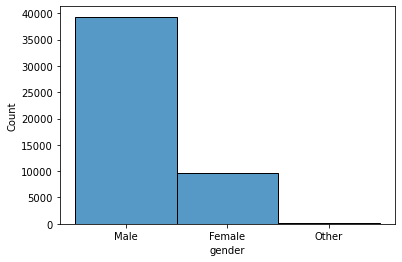

In [6]:
sns.histplot(data=df, x='gender')

In [7]:
# unbalanced dataset - there are more males than females
male_indices = df[df.gender == 'Male'].index
sample_size = sum(df.gender == 'Female')
random_indices = np.random.choice(male_indices, sample_size, replace=False)
male_samples = df.loc[random_indices]
df_gender = pd.concat([df[df.gender == 'Female'], male_samples])

In [13]:
clf, model, size, X, y = select_predictors(df_gender, ft_language, 'gender')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

X_new = model.transform(X.to_numpy())
y_new = y.map(gender_dict).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)
reg_gender = GradientBoostingRegressor(random_state=0)
reg_gender.fit(X_train, y_train)
reg_gender.predict(X_test)
print('\nR2-score for {} is: {:.4f}'.format('gender', reg_gender.score(X_test, y_test)))

Input data size: (19438, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.02417755 0.0111512  0.05416927 0.00534899 0.00631087 0.00476173
 0.00457462 0.07985724 0.00856215 0.0783372  0.08043654 0.07333623
 0.01987687 0.01737908 0.01628049 0.09032368 0.05646137 0.05940189
 0.05308613 0.06091854 0.01961737 0.0157459  0.01821439 0.14167069]
R2-score for gender is: 0.0002


In [98]:
df_new = pd.DataFrame(X_new, columns=ft_selected)
df_new.head(5)

,",_per_sentence",sign_per_token,approx_word_count,token_count,adj_per_word,verb_per_word,base_ratio,pres_ratio,past_ratio,pronoun_per_word,sentiment
0,1.000000,0.166667,5.0,6.0,0.000000,0.200000,-1.000000,1.000000,-1.000000,0.000000,0.500
1,3.000000,0.129032,27.0,31.0,0.000000,0.111111,-0.333333,0.333333,-1.000000,0.037037,0.220
2,0.333333,0.105263,34.0,38.0,0.058824,0.205882,-0.714286,-0.142857,-0.142857,0.117647,0.254
3,2.000000,0.074074,25.0,27.0,0.080000,0.160000,-0.500000,0.000000,-0.500000,0.040000,0.188
4,1.000000,0.111111,8.0,9.0,0.000000,0.250000,0.000000,0.000000,-1.000000,0.125000,0.000


In [26]:
ft_gender = ['!_per_sentence', 'punctuation_per_sentence', 'self_ratio', 'union_ratio']
df_gender_stats = df[(df.gender== 'Male') | (df.gender == 'Female')]
X_new = df_gender_stats[ft_gender].to_numpy()
y_new = df_gender_stats.gender.map(gender_dict).to_numpy()

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=0)
reg_gender = GradientBoostingRegressor(random_state=0)
reg_gender.fit(X_train, y_train)
reg_gender.predict(X_test)
print('\nR2-score for {} based on statistically significant features is: {:.4f}'.format('gender', reg_gender.score(X_test, y_test)))

R2-score for gender is: 0.0102


### Academic degree

<AxesSubplot:xlabel='academic_degree', ylabel='Count'>

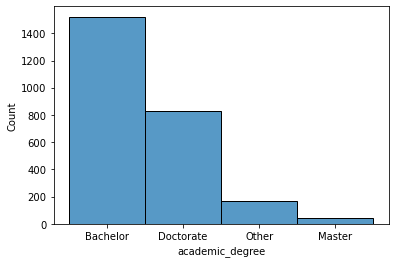

In [120]:
sns.histplot(data=df, x='academic_degree')

In [78]:
df_degree = get_balanced_sample('academic_degree', degree_dict, sample_size=50)

Year: 2015
Chunk: 0 (3, 33)
Chunk: 50 (4146, 33)
Chunk: 100 (8127, 33)
Chunk: 150 (12165, 33)
Year: 2016
Chunk: 0 (14556, 33)
Chunk: 50 (19305, 33)
Chunk: 100 (24132, 33)
Year: 2017
Chunk: 0 (26130, 33)
Chunk: 50 (31176, 33)
Chunk: 100 (36186, 33)
Chunk: 150 (40869, 33)
Chunk: 200 (45735, 33)
Year: 2018
Chunk: 0 (48510, 33)
Chunk: 50 (53646, 33)
Chunk: 100 (58953, 33)
Chunk: 150 (64017, 33)
Chunk: 200 (68811, 33)
Year: 2019
Chunk: 0 (72501, 33)
Chunk: 50 (77664, 33)
Chunk: 100 (82614, 33)
Chunk: 150 (87711, 33)
Year: 2020
Chunk: 0 (92070, 33)


In [79]:
# run feature selection
clf, model, size, X, y = select_predictors(df_degree, ft_language, 'academic_degree')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

X_new = model.transform(X.to_numpy())
y_new = y.map(degree_dict).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)
reg_degree = GradientBoostingRegressor(random_state=0)
reg_degree.fit(X_train, y_train)
reg_degree.predict(X_test)
print('\nR2-score for {} is: {:.4f}'.format('academic degree', reg_degree.score(X_test, y_test)))

Input data size: (96138, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.01983261 0.0084757  0.04947579 0.00304701 0.00550833 0.00500211
 0.00501664 0.07668625 0.00620139 0.07430817 0.07747841 0.07737043
 0.0134027  0.01110188 0.00902445 0.09227838 0.05126458 0.05287245
 0.04442476 0.05285523 0.01083319 0.01109454 0.01135482 0.23109017]

R2-score for academic degree is: 0.0104


### Religion

<AxesSubplot:xlabel='religion', ylabel='Count'>

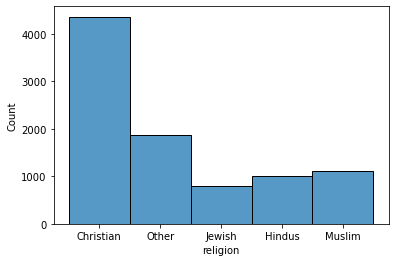

In [125]:
sns.histplot(data=df, x='religion')

In [80]:
# sample based on at most 50 samples per chunk
df_religion = get_balanced_sample('religion', religion_dict, sample_size=50)

Year: 2015
Chunk: 0 (200, 33)
Chunk: 50 (10200, 33)
Chunk: 100 (20200, 33)
Chunk: 150 (30200, 33)
Year: 2016
Chunk: 0 (36600, 33)
Chunk: 50 (46600, 33)
Chunk: 100 (56600, 33)
Year: 2017
Chunk: 0 (61000, 33)
Chunk: 50 (71000, 33)
Chunk: 100 (81000, 33)
Chunk: 150 (91000, 33)
Chunk: 200 (101000, 33)
Year: 2018
Chunk: 0 (106200, 33)
Chunk: 50 (116200, 33)
Chunk: 100 (126200, 33)
Chunk: 150 (136200, 33)
Chunk: 200 (146200, 33)
Year: 2019
Chunk: 0 (153000, 33)
Chunk: 50 (163000, 33)
Chunk: 100 (173000, 33)
Chunk: 150 (183000, 33)
Year: 2020
Chunk: 0 (191400, 33)


In [169]:
clf, model, size, X, y = select_predictors(df_religion, ft_language, 'religion')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

X_new = model.transform(X.to_numpy())
y_new = y.map(religion_dict).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)
reg_religion = GradientBoostingRegressor(random_state=0)
reg_religion.fit(X_train, y_train)
reg_religion.predict(X_test)
print('\nR2-score for {} is: {:.4f}'.format('religion', reg_religion.score(X_test, y_test)))

Input data size: (60800, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.02093129 0.00778008 0.04888437 0.00373812 0.00604137 0.00457179
 0.00590555 0.07732031 0.00518965 0.07627615 0.07861407 0.07507428
 0.01524465 0.01244886 0.01125301 0.0917578  0.05143069 0.05324408
 0.04646702 0.05892601 0.02065685 0.01776882 0.02191606 0.18855913]


### Occupation

<AxesSubplot:xlabel='occupation', ylabel='Count'>

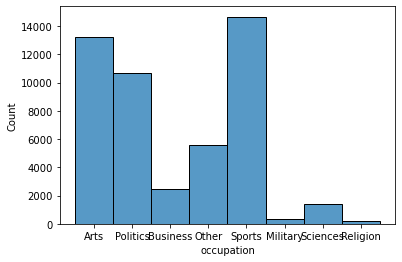

In [149]:
sns.histplot(data=df, x='occupation')

In [29]:
df_occupation = get_balanced_sample('occupation', occupation_dict, sample_size=50)

Year: 2015
Chunk: 0 (144, 33)
Chunk: 50 (7344, 33)
Chunk: 100 (13296, 33)
Chunk: 150 (15296, 33)
Year: 2016
Chunk: 0 (16576, 33)
Chunk: 50 (18576, 33)
Chunk: 100 (20576, 33)
Year: 2017
Chunk: 0 (21480, 33)
Chunk: 50 (22024, 33)
Chunk: 100 (22024, 33)
Chunk: 150 (22024, 33)
Chunk: 200 (22024, 33)
Year: 2018
Chunk: 0 (22024, 33)
Chunk: 50 (22024, 33)
Chunk: 100 (22024, 33)
Chunk: 150 (22024, 33)
Chunk: 200 (22024, 33)
Year: 2019
Chunk: 0 (22024, 33)
Chunk: 50 (22024, 33)
Chunk: 100 (22024, 33)
Chunk: 150 (22024, 33)
Year: 2020
Chunk: 0 (22024, 33)


In [172]:
clf, model, size, X, y = select_predictors(df_occupation, ft_language, 'occupation')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

Input data size: (22024, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.02261687 0.01259157 0.05287016 0.00342633 0.00534335 0.00480018
 0.00552291 0.08274954 0.01039336 0.08088131 0.08283764 0.0753292
 0.01816665 0.01497838 0.01330887 0.09262835 0.05682847 0.06101039
 0.05190184 0.05940595 0.01461531 0.01336383 0.01531407 0.14911548]


In [173]:
X_new = model.transform(X.to_numpy())
y_new = y.map(occupation_dict).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)
reg_occupation = GradientBoostingRegressor(random_state=0)
reg_occupation.fit(X_train, y_train)
reg_occupation.predict(X_test)
print('R2-score for {} is: {:.4f}'.format('occupation', reg_occupation.score(X_test, y_test)))

R2-score for occupation is: 0.0009


In [45]:
ft_occupation = ['sentence_count', '!_per_sentence', 'sign_per_token', 'verb_per_word', 'pronoun_per_word', 'union_ratio', 'sentiment']
df_occupation_stats = df[df.occupation != 'Other'].dropna()
X_new = df_occupation_stats[ft_occupation].to_numpy()
y_new = df_occupation_stats.occupation.map(occupation_dict).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=0)
reg_occupation_stats = GradientBoostingRegressor(random_state=0)
reg_occupation_stats.fit(X_train, y_train)
reg_occupation_stats.predict(X_test)
print('R2-score for {} based on statistically significant features is: {:.4f}'.format('occupation', reg_occupation_stats.score(X_test, y_test)))

R2-score for occupation based on statistically significant features is: -0.0013


### Nationality

D:\Software\anaconda\envs\ada\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


<AxesSubplot:xlabel='nationality', ylabel='Count'>

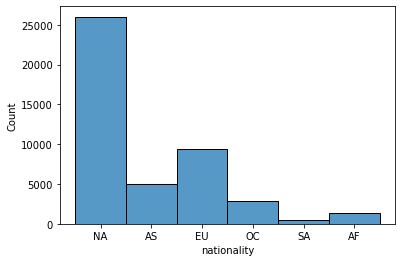

In [52]:
df_continent = group_nation_by_continent(df)
sns.histplot(data=df_continent, x='nationality')

In [54]:
clf, model, size, X, y = select_predictors(df_continent, ft_language, 'nationality')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

X_new = model.transform(X.to_numpy())
y_new = y.map(continent_dict).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)
reg_continent = GradientBoostingRegressor(random_state=0)
reg_continent.fit(X_train, y_train)
reg_continent.predict(X_test)
print('R2-score for {} is: {:.4f}'.format('continent', reg_continent.score(X_test, y_test)))

Input data size: (45105, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.02362731 0.01011103 0.04925463 0.0042212  0.00541504 0.00429843
 0.00480049 0.07991145 0.00695108 0.0759161  0.07805043 0.07399329
 0.0143886  0.01184857 0.00993514 0.09077397 0.05556236 0.05861028
 0.05149793 0.06312715 0.0218864  0.01823357 0.02188001 0.16570553]
R2-score for continent is: 0.0191


###  Generation

In [46]:
def GroupBirthDates(sample):
    birth = sample.copy()
    birth["date_of_birth"] = birth["date_of_birth"].astype(int)
    birth["date_of_birth"] = birth["date_of_birth"].apply(lambda x: '30s' if x < 1940 else '50s' if x < 1960 else '70s' if x < 1980  else '90s' if x < 2000 else '00s' if x < 2020 else x)
    return birth

<AxesSubplot:xlabel='date_of_birth', ylabel='Count'>

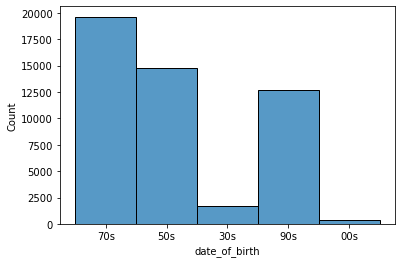

In [55]:
df_generation = GroupBirthDates(df)
sns.histplot(data=df_generation, x="date_of_birth")

In [62]:
clf, model, size, X, y = select_predictors(df_generation, ft_language, 'date_of_birth')
print('Input data size: ' + str(size))
print(model.get_feature_names_out(ft_language))
print(clf.feature_importances_)

X_new = model.transform(X.to_numpy())
y_new = y.map(generation_dict).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state=0)

reg_generation = GradientBoostingRegressor(random_state=0)
reg_generation.fit(X_train, y_train)
reg_generation.predict(X_test)
print('R2-score for {} is: {:.4f}'.format('continent', reg_generation.score(X_test, y_test)))

Input data size: (49235, 25)
[',_per_sentence' 'sign_per_token' 'approx_word_count' 'token_count'
 'adj_per_word' 'verb_per_word' 'base_ratio' 'pres_ratio' 'past_ratio'
 'pronoun_per_word' 'sentiment']
[0.02293171 0.01101902 0.05172007 0.00406098 0.00615502 0.00434455
 0.00456564 0.07905542 0.00806188 0.07528456 0.07777289 0.07305781
 0.01773783 0.01541201 0.0130558  0.09038725 0.05436512 0.05894164
 0.05118183 0.06480109 0.01864507 0.01676033 0.01656568 0.16411679]
R2-score for continent is: 0.0227


In [64]:
ft_generation = ['pronoun_per_word', 'self_ratio', 'union_ratio']
X_new = df_generation[ft_generation].to_numpy()
y_new = df_generation.date_of_birth.map(generation_dict).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=0)
reg_generation_stats = GradientBoostingRegressor(random_state=0)
reg_generation_stats.fit(X_train, y_train)
reg_generation_stats.predict(X_test)
print('R2-score for {} based on statistically significant features is: {:.4f}'.format('generation', reg_generation_stats.score(X_test, y_test)))

R2-score for generation based on statistically significant features is: 0.0341


## Feature agglomeration

Was not used because it is difficult to understand the meaning of combined language features.

In [56]:
X = df[ft_language].copy().to_numpy()
X.shape

(1000000, 24)

In [57]:
agglo = cluster.FeatureAgglomeration(n_clusters=None, distance_threshold=120)
agglo.fit(X)
X_reduced = agglo.transform(X)
X_reduced.shape

(1000000, 22)

In [58]:
df_new = pd.DataFrame(X_reduced)
df_new.head(5)

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,0.194444,-0.478,1.0,0.0,-1.0,-1.0,-1.0,12.0,0.0,0.0,...,-1.0,9.0,1.0,0.0,1.0,0.0,0.333333,0.0,0.0,0.0
1,0.080655,0.301,0.0,1.0,-1.0,0.0,-1.0,35.0,-1.0,0.0,...,-1.0,32.0,1.0,0.0,1.0,-1.0,0.187500,0.0,0.0,0.0
2,0.191667,-0.636,0.0,0.0,0.0,0.0,-1.0,10.0,0.0,0.0,...,-1.0,8.0,1.0,0.0,1.0,0.0,0.000000,1.0,0.0,0.0
3,0.028382,0.291,-0.6,0.0,-0.6,0.2,-1.0,24.0,0.0,0.0,...,-1.0,23.0,1.0,0.0,0.0,0.0,0.217391,1.0,0.0,0.0
4,0.022222,0.000,0.0,0.0,0.0,-1.0,0.0,15.0,0.0,0.0,...,0.0,14.0,0.0,0.0,1.0,0.0,0.142857,0.0,0.0,0.0
